In [1]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp

# https://wiki.python.org/moin/UsingPickle
import pickle

Queries = "/user/home/user120/proj1_dataset/topics-2014_2015-summary.topics"
Qrels = "/user/home/user120/proj1_dataset/qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

eval = trec.TrecEvaluation(cases, Qrels)

# pp.pprint(cases)


In [2]:
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("/user/home/user120/proj1_dataset/clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
i = 0
ids = []
docs = []
for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True

        if judged is False:
            continue

        i = i + 1

        for brief_title in root.iter('brief_title'):
            #print("brief_title: ", brief_title.text)
            docs.append(brief_title.text)
            ids.append(doc_id.text)

        continue

        for detailed_description in root.iter('detailed_description'):
            for child in detailed_description:
                print("detailed_description: ", child.text.strip())

        for brief_summary in root.iter('brief_summary'):
            for child in brief_summary:
                print("brief_summary: ", child.text.strip())
tar.close()

print(i)

pickle.dump(docs, open( "documents.bin", "wb" ) )
pickle.dump(ids, open( "doc_ids.bin", "wb" ) )


3626


In [2]:
import pickle
docs = pickle.load( open( "documents.bin", "rb" ) )
ids = pickle.load( open( "doc_ids.bin", "rb" ) )

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

index = TfidfVectorizer(ngram_range=(1,1), analyzer='word', stop_words = None)
index.fit(docs)

# Compute the corpus representation
X = index.transform(docs)


In [3]:
avg_precision_11point = np.zeros(11)
for caseid in cases:
    query = cases[caseid]
    query_tfidf = index.transform([query])

    doc_scores = 1 - pairwise_distances(X, query_tfidf, metric='cosine')
    
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    
    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
    [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

    if (np.shape(recall_11point) != (0,)):
        avg_precision_11point = avg_precision_11point + precision_11point

    print(ap)


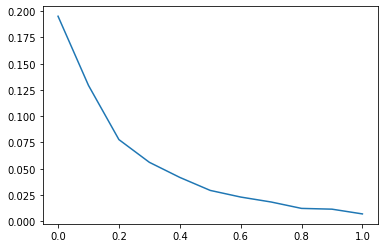

In [6]:
import matplotlib.pyplot as plt
plt.plot(recall_11point,avg_precision_11point/len(cases))
